# Glauber with periodic time on a tree

In [2]:
using MatrixProductBP, MatrixProductBP.Models
using Plots, Graphs, Statistics
import ProgressMeter; ProgressMeter.ijulia_behavior(:clear)
using LaTeXStrings
using Graphs, IndexedGraphs, Random
import BeliefPropagation;

[ Info: Precompiling BeliefPropagation [f47dce41-c8ad-4b69-b8b4-f2a36c7ebdf8]


In [49]:
T = 50
J = 0.8
β = 1.0
h = 0.2
m⁰ = 0.5
rng = MersenneTwister(0)
N = 8
gg = prufer_decode(rand(rng, 1:N, N-2))
add_edge!(gg, 2, 8)
g = gg |> IndexedGraph
ising = Ising(J * adjacency_matrix(g), h*ones(nv(g)), β)
gl = Glauber(ising, T)
ϕᵢ = [ t == 0 ? [(1+m⁰)/2, (1-m⁰)/2] : ones(2) for t in 0:T]
bp = periodic_mpbp(gl)
cb = CB_BP(bp);

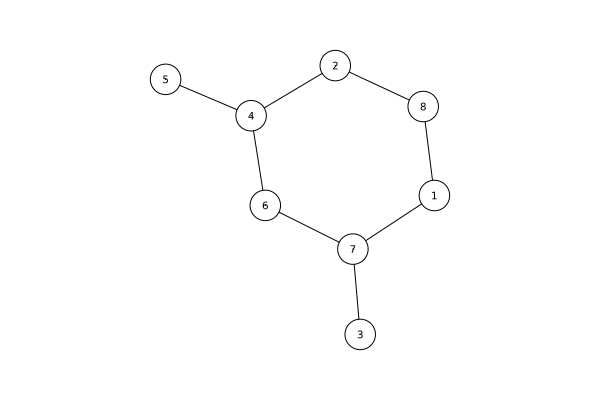

In [50]:
using GraphRecipes
graphplot(g, curves=false, nodeshape=:circle, names=string.(1:N), nodecolor=:white, nodesize=0.3)

In [51]:
bp_static = BeliefPropagation.BP(BeliefPropagation.Models.Ising(J * adjacency_matrix(g), h*ones(nv(g)), β))
BeliefPropagation.iterate!(bp_static; maxiter=100)
m_static = reduce.(-, BeliefPropagation.beliefs(bp_static)) |> mean

0.7353957764710235

In [ ]:
svd_trunc=TruncBondThresh(10, 1e-6)
iters, cb = iterate!(bp; maxiter=20, svd_trunc, cb, tol=1e-5, damp=0.0);

Running MPBP: iter 33    Time: 0:06:11
  Δ:                  0.0002870969726456174


In [ ]:
using InvertedIndices
plot(cb.Δs[Not(iszero.(cb.Δs))], ylabel="convergence error", xlabel="iters", yaxis=:log10, legend=:outertopright,
    size=(300,200))

In [ ]:
spin(x, i) = 3-2x
spin(x) = spin(x, 0)
m = mean(means(spin, bp));

In [ ]:
pl = scatter(m, label="MPBP")
hline!(pl, [m_static], label="equilibrium", ylims=m_static .+ 1e-1 .* (-1, 1))

In [ ]:
using TensorTrains
bond_dims.(bp.μ)

In [78]:
bp2 = mpbp(Glauber(ising, 500))
for t in eachindex(bp2.w[2])
    bp2.w[2][t] = HomogeneousGlauberFactor(0.6, 0.2)
end
sms = SoftMarginSampler(bp2)
sample!(sms, 10^6);

SoftMargin sampling 100%|████████████████████████████████| Time: 0:01:5939m


In [79]:
m_mc = marginals(sms);

In [119]:
bp3 = mpbp(Glauber(ising, 10^7))
for t in eachindex(bp3.w[2])
    bp3.w[2][t] = HomogeneousGlauberFactor(0.6, 0.2)
end
sms2 = SoftMarginSampler(bp3)
sample!(sms2, 1);

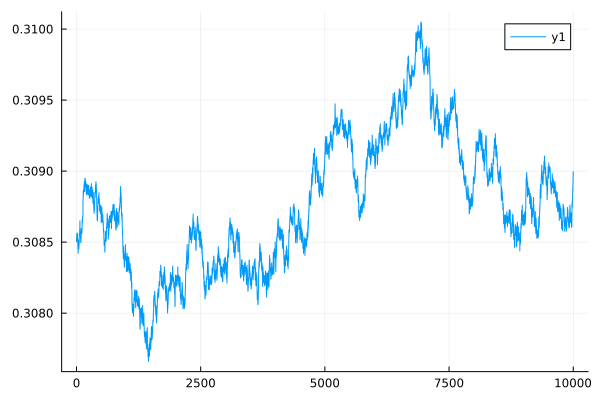

In [120]:
x = sms2.X[1][1,:]
τ = 10^6
z = cumsum(x)
y = [(z[t] - z[t-τ])/τ for t in length(x)-τ:length(x)] .|> potts2spin
plot(y[1:100:end])

In [121]:
potts2spin(x) = 3-2x
potts2spin.(mean(sms2.X[1][:,end-10^6:end], dims=2))

2×1 Matrix{Float64}:
 0.3089666910333091
 0.30133869866130114

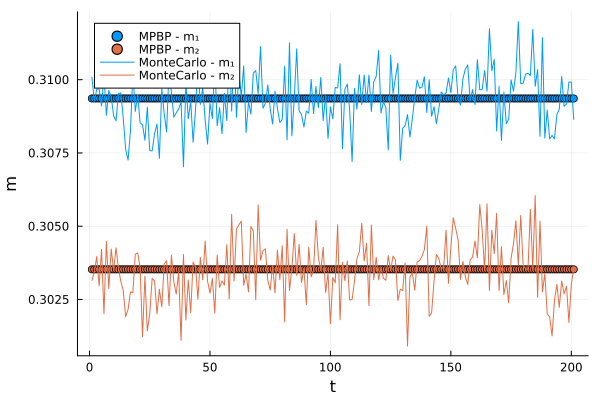

In [122]:
pl2 = deepcopy(pl)
# plot!(pl2, getfield.(reduce.(-, m_mc[1][end-T:end]), :val), label="MonteCarlo - m₁", c=theme_palette(:auto)[1])
# plot!(pl2, getfield.(reduce.(-, m_mc[2][end-T:end]), :val), label="MonteCarlo - m₂", c=theme_palette(:auto)[2])

# hline!(pl2, [mean(getfield.(reduce.(-, m_mc[1][end-T:end]), :val))], label="MonteCarlo - m₁", c=theme_palette(:auto)[1])
# hline!(pl2, [mean(getfield.(reduce.(-, m_mc[2][end-T:end]), :val))], label="MonteCarlo - m₂", c=theme_palette(:auto)[2])

In [8]:
import TensorTrains
TensorTrains.bond_dims.(bp.μ)

10-element Vector{Vector{Int64}}:
 [2, 2, 2, 2, 2, 2, 2, 2, 2, 2  …  2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
 [2, 2, 2, 2, 2, 2, 2, 2, 2, 2  …  2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
 [18, 17, 17, 17, 17, 17, 17, 17, 17, 17  …  17, 17, 17, 17, 17, 17, 17, 17, 17, 18]
 [18, 17, 17, 17, 17, 17, 17, 17, 17, 17  …  17, 17, 17, 17, 17, 17, 17, 17, 17, 18]
 [6, 5, 5, 5, 5, 5, 5, 5, 5, 5  …  5, 5, 5, 5, 5, 5, 5, 5, 6, 6]
 [2, 2, 2, 2, 2, 2, 2, 2, 2, 2  …  2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
 [18, 17, 17, 17, 17, 17, 17, 17, 17, 17  …  17, 17, 17, 17, 17, 17, 17, 17, 17, 17]
 [6, 5, 5, 5, 5, 5, 5, 5, 5, 5  …  5, 5, 5, 5, 5, 5, 5, 5, 6, 6]
 [18, 17, 17, 17, 17, 17, 17, 17, 17, 17  …  17, 17, 17, 17, 17, 17, 17, 17, 17, 17]
 [2, 2, 2, 2, 2, 2, 2, 2, 2, 2  …  2, 2, 2, 2, 2, 2, 2, 2, 2, 2]